In [1]:
import altair as alt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

# Exploratory data analysis of Crime in Vancouver #

The data set used in this project comes from **the Vancouver Open Data Catalogue**. It includes 529.652 crimes reported between January 1, 2003 to July 13, 2017. The data set is also avialable on <https://www.kaggle.com/wosaku/crime-in-vancouver>

In [2]:
df = pd.read_csv('../data/raw/crimedata_csv_all_years.csv')
df = df.query('YEAR <=2020')

### Split data into train set and test set

In [3]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=123)

## Peek at the data ##

**The following few data illustrates the train data set we will be analyzing. In total there are 9 features (`TYPE`,`YEAR`, `MONTH`, `DAY`, `HOUR`, `MINUTE`, `HUNDRED_BLOCK`, `NEIGHBOURHOOD`, `X`, `Y`) and one target column `TYPE`.**

In [4]:
print(f"The train dataset has {train_df.shape[0]} rows and {train_df.shape[1]} variables ")

The train dataset has 626208 rows and 10 variables 


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626208 entries, 265584 to 801930
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           626208 non-null  object 
 1   YEAR           626208 non-null  int64  
 2   MONTH          626208 non-null  int64  
 3   DAY            626208 non-null  int64  
 4   HOUR           626208 non-null  int64  
 5   MINUTE         626208 non-null  int64  
 6   HUNDRED_BLOCK  626198 non-null  object 
 7   NEIGHBOURHOOD  626111 non-null  object 
 8   X              626155 non-null  float64
 9   Y              626155 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 52.6+ MB


In [6]:
print(f"Vancouver has {train_df['NEIGHBOURHOOD'].nunique()} neighborhoods, and they are")

Vancouver has 24 neighborhoods, and they are


In [7]:
train_df['NEIGHBOURHOOD'].unique()

array(['Killarney', 'Kensington-Cedar Cottage', 'Grandview-Woodland',
       'Central Business District', 'Victoria-Fraserview', 'West End',
       'Oakridge', 'Renfrew-Collingwood', 'Mount Pleasant', 'Fairview',
       'Kitsilano', 'Hastings-Sunrise', 'Sunset', 'South Cambie',
       'Strathcona', 'West Point Grey', 'Riley Park', 'Shaughnessy',
       'Kerrisdale', 'Marpole', 'Arbutus Ridge', 'Dunbar-Southlands',
       'Stanley Park', 'Musqueam', nan], dtype=object)

In [8]:
print(
    f"dataset has information for {train_df['YEAR'].nunique()} years. From {train_df['YEAR'].unique().min()} to {train_df['YEAR'].unique().max()}"
)

dataset has information for 18 years. From 2003 to 2020


In [9]:
numerics = train_df.select_dtypes(include=np.number).columns.tolist()

train_df[numerics].describe()

,YEAR,MONTH,DAY,HOUR,MINUTE,X,Y
count,626208.000000,626208.000000,626208.000000,626208.000000,626208.000000,626155.000000,6.261550e+05
mean,2011.049872,6.545510,15.407671,12.405472,15.688869,450251.974246,4.991821e+06
std,5.444183,3.407645,8.761462,7.445478,18.285131,137446.334223,1.523575e+06
min,2003.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2006.000000,4.000000,8.000000,7.000000,0.000000,490181.655750,5.454252e+06
50%,2011.000000,7.000000,15.000000,14.000000,5.000000,491556.822500,5.457171e+06
75%,2016.000000,9.000000,23.000000,19.000000,30.000000,493390.728200,5.458718e+06
max,2020.000000,12.000000,31.000000,23.000000,59.000000,511303.000000,5.512579e+06


**From the data shown above, we will require to perform scaling of the numeric features and One Hot Encoding on categorical features. Also some of the features might consider to be dropped, for example `X` and `Y`, which represents the specific coordinate values of UTM zone 10.**

## Explore trends, relationships and more ##

**As we can observe below, `Theft from Vehicle` is with highest occurrence throughout the years. Are there any particular relationship in specific neighbourhood?**

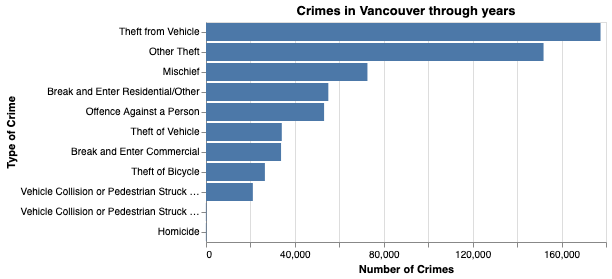

In [10]:
alt.Chart(train_df, title='Crimes in Vancouver through years').mark_bar().encode(
    y=alt.Y('TYPE', sort='-x', title='Type of Crime'),
    x=alt.X('count()', title='Number of Crimes'))

**The following illustrates the types of crimes in relates to different neighbourhood. Again, high occurrence is observed between `Theft from Vehicle` and different neighbourhood.**

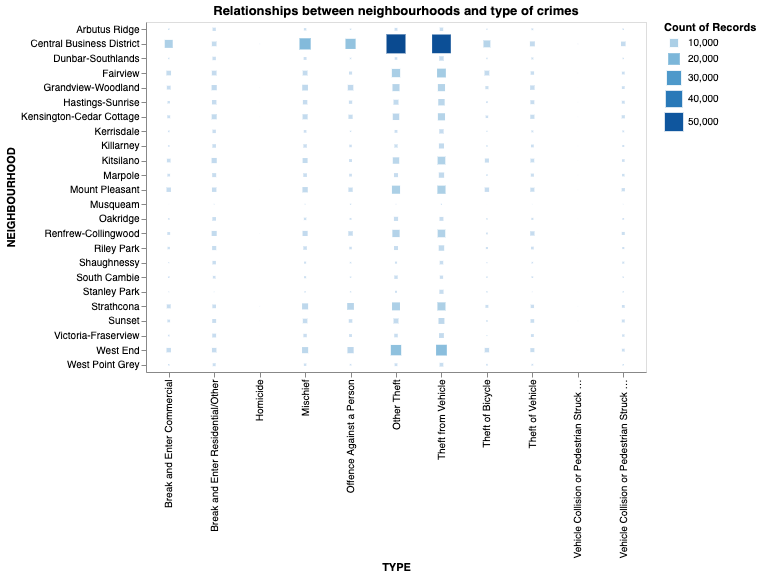

In [11]:
alt.Chart(train_df.dropna(), 
          title = "Relationships between neighbourhoods and type of crimes"
         ).mark_square().encode(
    x='TYPE',
    y='NEIGHBOURHOOD',
    color='count()',
    size='count()').properties(
    width=500,
    height=350
)

**We also conducted a trend analysis on the evolution of crimes over the year. The number of cases related to `Theft of Vehicle` dropped from 2004, but climed up again since 2011. It would be useful to observe how the prediction model captures the time changes.**

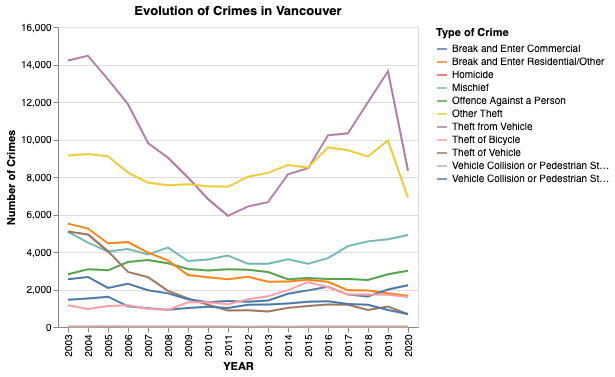

In [12]:
alt.Chart(train_df,title ='Evolution of Crimes in Vancouver').mark_line().encode(
    x=alt.X('YEAR:O'),
    y=alt.Y('count(YEAR)', title ='Number of Crimes'),
    color=alt.Color('TYPE', title='Type of Crime'))

**The following illustrates the distribution of crimes per hour.** From the graph, there is a significantly amount of crime committed at 0:00 AM. This appears to be an issue within the data collection. Many crimes are logged at 0 AM as a default in cases where the original time of the crime is unknown or not available. Also, based on the data description provided by the VPD, the hour information was based on the findings of the police investigation, which may not always be accurate or exact. See [here](https://github.com/jasmineortega/DSCI_522_Crime_Prediction_Vancouver/blob/main/data/raw/VPD%20OpenData%20Crime%20Incidents%20Description.pdf) for the data specification. Therefore, the high number of crimes at 0:00 AM is unbalanced. Data balancing should be a consideration in the model training phase and/or hyperparameter optimization. 

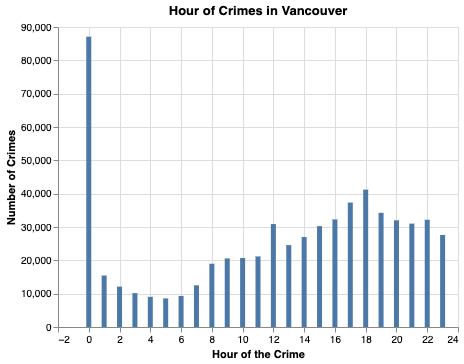

In [13]:
alt.Chart(train_df, title="Hour of Crimes in Vancouver").mark_bar(clip=True).encode(
    x=alt.X(
        "HOUR",
        title="Hour of the Crime",
        scale=alt.Scale(domain=(0, 23)),
        axis=alt.Axis(format="d")
        ,
    ),
    y=alt.Y("count()", title="Number of Crimes"),
)

**The following shows the number of crimes against each month. It seems that there are no clear relationship.**

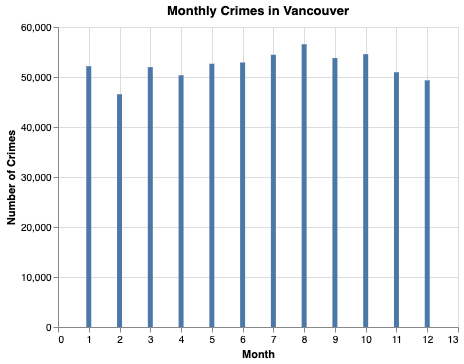

In [14]:
alt.Chart(train_df, title='Monthly Crimes in Vancouver').mark_bar(clip=True).encode(
    x=alt.X('MONTH', title='Month', scale=alt.Scale(domain=(1, 12))),
    y=alt.Y('count()', title='Number of Crimes'))

In [15]:
%load_ext rpy2.ipython

In [16]:
%%R
library(tidyverse)
library(knitr)
library(ggridges)
library(ggthemes)
library(ggplot2)
theme_set(theme_gray(base_size = 18))

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Import train data into R for further EDA

In [17]:
%%R -i train_df
train_df |> head()

                                    TYPE YEAR MONTH DAY HOUR MINUTE
265584          Offence Against a Person 2018     6  17    0      0
124736                          Mischief 2019     3  22   11      0
59309  Break and Enter Residential/Other 2009     4  18   20     35
491018                Theft from Vehicle 2015     8  15    0     16
774604                  Theft of Vehicle 2008     6  21   20      0
290845                       Other Theft 2010    11   9    4      4
                   HUNDRED_BLOCK             NEIGHBOURHOOD        X       Y
265584 OFFSET TO PROTECT PRIVACY                 Killarney      0.0       0
124736           13XX E 10TH AVE  Kensington-Cedar Cottage 494436.9 5456514
59309            18XX FRANCES ST        Grandview-Woodland 495040.0 5458508
491018              11XX HOWE ST Central Business District 490860.5 5458453
774604         76XX MUIRFIELD DR       Victoria-Fraserview 495929.8 5451344
290845             11XX DAVIE ST                  West End 490305.9 

**Below table shows the type of crime with its reported times, as well as percentage**

In [18]:
%%R
type_crime <- train_df |>
  group_by(TYPE) |>
  summarise(Count = n()) |>
  mutate(Percentage = paste0(round(Count / sum(Count) * 100, 2), "%")) |>
  arrange(desc(Count))
type_crime

# A tibble: 11 × 3
   TYPE                                                    Count Percentage
   <chr>                                                   <int> <chr>     
 1 Theft from Vehicle                                     177545 28.35%    
 2 Other Theft                                            151897 24.26%    
 3 Mischief                                                72648 11.6%     
 4 Break and Enter Residential/Other                       55052 8.79%     
 5 Offence Against a Person                                53141 8.49%     
 6 Theft of Vehicle                                        34106 5.45%     
 7 Break and Enter Commercial                              33775 5.39%     
 8 Theft of Bicycle                                        26505 4.23%     
 9 Vehicle Collision or Pedestrian Struck (with Injury)    21083 3.37%     
10 Vehicle Collision or Pedestrian Struck (with Fatality)    238 0.04%     
11 Homicide                                                  218 0.03

**By visualization**

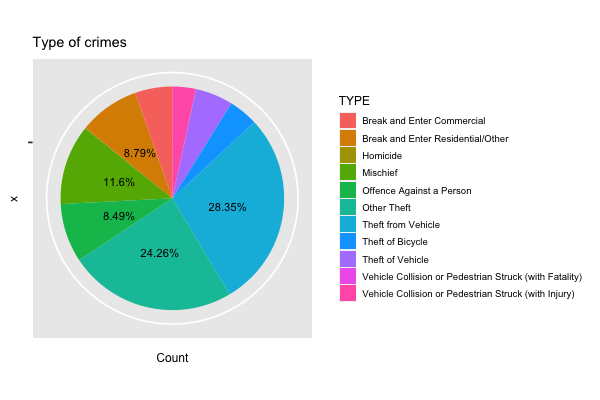

In [19]:
%%R -w 600 -h 400
ggplot(type_crime, aes(x = "", y = Count, fill = TYPE)) +
  geom_col() +
  geom_text(aes(label = ifelse(Count > 50000, Percentage, "")),
            position = position_stack(vjust = 0.5),
            show.legend = FALSE,
            size = 4) +
  coord_polar(theta = "y") +
  scale_y_discrete() +
  theme(text = element_text(size = 12)) +
  ggtitle("Type of crimes")

**Below table and visualization show the number of crimes per neighbourhood**

In [20]:
%%R
# Count Neighbourhood with most crimes
neighbour_crime <- train_df |>
  group_by(NEIGHBOURHOOD) |>
  summarize(Count = n()) |>
  arrange(desc(Count))

neighbour_crime[-c(2),] # Remove crime without Neighbourhood data

# A tibble: 24 × 2
   NEIGHBOURHOOD              Count
   <chr>                      <int>
 1 Central Business District 166018
 2 Strathcona                 39505
 3 Fairview                   39242
 4 Mount Pleasant             39168
 5 Grandview-Woodland         35894
 6 Renfrew-Collingwood        32761
 7 Kitsilano                  31275
 8 Kensington-Cedar Cottage   29917
 9 Hastings-Sunrise           21946
10 Sunset                     20554
# … with 14 more rows


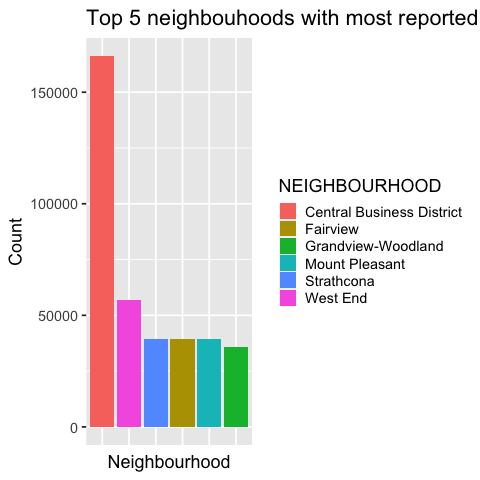

In [21]:
%%R
top_5_district <- head(neighbour_crime)
ggplot(top_5_district) +
  geom_bar(aes(x = reorder(NEIGHBOURHOOD, -Count),
               y = Count, fill = NEIGHBOURHOOD), 
           stat = "identity") +
  theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank()) +
  xlab("Neighbourhood") +
  ggtitle("Top 5 neighbouhoods with most reported crimes")

**Though this exploratory data analysis, we have been able to estimate the most common crimes in Vancouver, as well as the neighborhoods with the most reported crimes. This information can be used to verify the results of our model's prediction. That is, if our model is successful, it should also be able to corroborate these findings.**